# Data Scientist Job Test – ShapeDigital

**Candidate:** Renan Vital  
**Email:** vitalrenan@outlook.com  
**Date:** 2025-09-01   
**GitHub:** https://github.com/Vitalrenan  
**Project:** We want you to investigate one piece of equipment in different time cycles to understand what characteristics and parameters of the sensors might indicate that the equipment is on the verge of failing.

----

In [1]:
# Importing essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import io
from scipy.stats import mode
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    roc_curve
)

# Setting up plot styles for better visualization
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 7)

# Load the provided dataset
try:
    df = pd.read_excel('Test O_G_Equipment_Data.xlsx')
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("Error: 'equipment_database.csv' not found. Please ensure the file is in the correct directory.")
    # Exit or handle the error appropriately
    # For this demonstration, I'll stop here if the file isn't found.
    exit()

Dataset loaded successfully.


#### Feature dictionary 
1.	Cycle: Sequential identifier of measurement cycles.
2.	Preset_1 & Preset_2: Variables that control a specific operating point of the machine.
3.	Temperature: Temperature recorded in the equipment.
4.	Vibrations (X, Y & Z): Vibrations along the machine's axes.
5.	Frequency: Operating frequency of the machine.
6.	Fail: Variable indicating whether the machine is in a failure state at the given timestamp.


In [2]:
df.head()

,Cycle,Preset_1,Preset_2,Temperature,Pressure,VibrationX,VibrationY,VibrationZ,Frequency,Fail
0,1,3,6,44.235186,47.657254,46.441769,64.820327,66.454520,44.483250,False
1,2,2,4,60.807234,63.172076,62.005951,80.714431,81.246405,60.228715,False
2,3,2,1,79.027536,83.032190,82.642110,98.254386,98.785196,80.993479,False
3,4,2,3,79.716242,100.508634,122.362321,121.363429,118.652538,80.315567,False
4,5,2,5,39.989054,51.764833,42.514302,61.037910,50.716469,64.245166,False


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Cycle        800 non-null    int64  
 1   Preset_1     800 non-null    int64  
 2   Preset_2     800 non-null    int64  
 3   Temperature  800 non-null    float64
 4   Pressure     800 non-null    float64
 5   VibrationX   800 non-null    float64
 6   VibrationY   800 non-null    float64
 7   VibrationZ   800 non-null    float64
 8   Frequency    800 non-null    float64
 9   Fail         800 non-null    bool   
dtypes: bool(1), float64(6), int64(3)
memory usage: 57.2 KB


In [4]:
df.describe()

,Cycle,Preset_1,Preset_2,Temperature,Pressure,VibrationX,VibrationY,VibrationZ,Frequency
count,800.0000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,400.5000,1.988750,4.551250,69.263494,78.997945,73.860275,72.786878,71.866211,68.223449
std,231.0844,0.805875,2.293239,25.536252,32.501834,31.229631,32.739745,27.844616,29.138702
min,1.0000,1.000000,1.000000,2.089354,3.480279,3.846343,10.057744,18.784169,4.380101
25%,200.7500,1.000000,3.000000,51.040134,55.508564,50.752461,48.523982,50.787638,45.861762
50%,400.5000,2.000000,5.000000,65.906716,75.014848,69.394953,65.504770,69.319237,65.664252
75%,600.2500,3.000000,7.000000,80.527220,99.302530,90.195059,94.075572,88.891205,90.097457
max,800.0000,3.000000,8.000000,255.607829,189.995681,230.861142,193.569947,230.951134,178.090303


In [5]:
df.isnull().sum()

Cycle          0
Preset_1       0
Preset_2       0
Temperature    0
Pressure       0
VibrationX     0
VibrationY     0
VibrationZ     0
Frequency      0
Fail           0
dtype: int64

----

### Task 1: Calculate How Many Times the Equipment Has Failed

During the FPSO’s operation, various factors can cause the machine to fail and prolong its failure state. We ask you to explore the available data, identify, and calculate the number of times the equipment has failed throughout its operation.

In [6]:
#Counting the number of times the variable 'Fail' was flagged
df.Fail.value_counts()

Fail
False    734
True      66
Name: count, dtype: int64

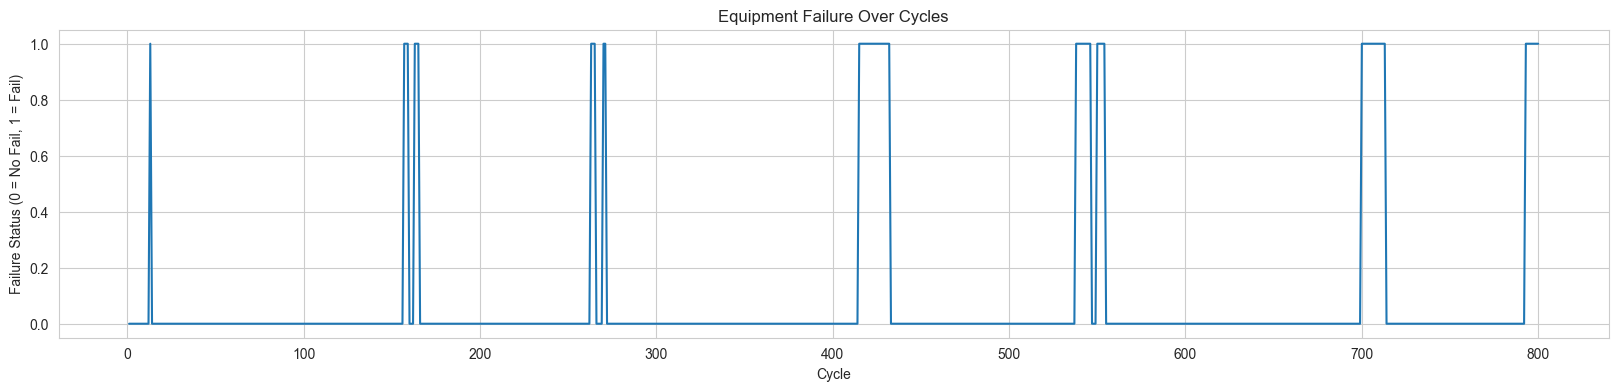

In [7]:
#Exploring one fail trend

fig = plt.figure(figsize=(20, 4))
sns.lineplot(data=df, x='Cycle', y='Fail')
plt.title('Equipment Failure Over Cycles')
plt.xlabel('Cycle')
plt.ylabel('Failure Status (0 = No Fail, 1 = Fail)')    
plt.show()

Looks like sometimes a failure status takes longer than 1 cicle. Then the number of failure must be the counting of fail state transitions.

In [8]:
df['fail_shift'] = df['Fail'].shift(1)
df['fail_transition'] = (df['Fail'] == 1) & (df['fail_shift'] == 0)
num_failures = df['fail_transition'].sum()
print(f"The equipment has failed {num_failures} times.")


The equipment has failed 10 times.


#### Solution for Task 1: The equipment has failed 10 times.

----

### Task 2: Preset_1 & Preset_2: Variables that control a specific operating point of the machine.

How do the variables Preset_1 and Preset_2 behave during operation? What insights can we derive from these variables?

In [9]:
#Analysing Preset's features
df.Preset_1.unique(), df.Preset_2.unique()

(array([3, 2, 1]), array([6, 4, 1, 3, 5, 2, 7, 8]))

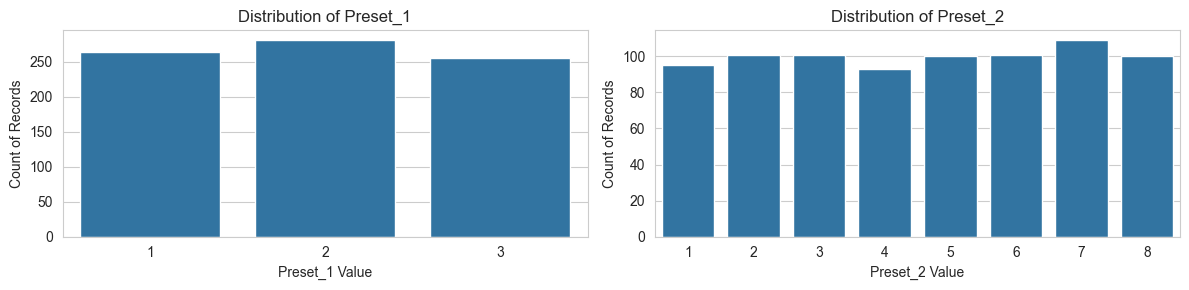

In [10]:
#Checking Preset's distributions
fig, axes = plt.subplots(1, 2, figsize=(12, 3))

sns.countplot(x='Preset_1', data=df, ax=axes[0])
axes[0].set_title('Distribution of Preset_1')
axes[0].set_xlabel('Preset_1 Value')
axes[0].set_ylabel('Count of Records')

sns.countplot(x='Preset_2', data=df, ax=axes[1])
axes[1].set_title('Distribution of Preset_2')
axes[1].set_xlabel('Preset_2 Value')
axes[1].set_ylabel('Count of Records')

plt.tight_layout()
plt.show()

Pearson's correlation on Preset's variables 

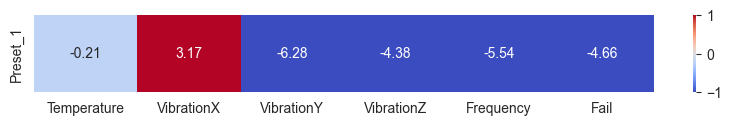

In [11]:
#Correlação de pearson sobre as demais variáveis para entender a relação em preset e o funcionamento do equipamento
columns_for_corr = ['Preset_1', 'Temperature', 'VibrationX', 'VibrationY', 'VibrationZ', 'Frequency', 'Fail']
correlation_matrix = df[columns_for_corr].corr(method='pearson')
correlation_matrix = correlation_matrix[correlation_matrix.Preset_1<1][['Preset_1']]*100
correlation_matrix = correlation_matrix.transpose()

plt.figure(figsize=(10, 1))
sns.heatmap(
    correlation_matrix, 
    annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1     
)
plt.show()

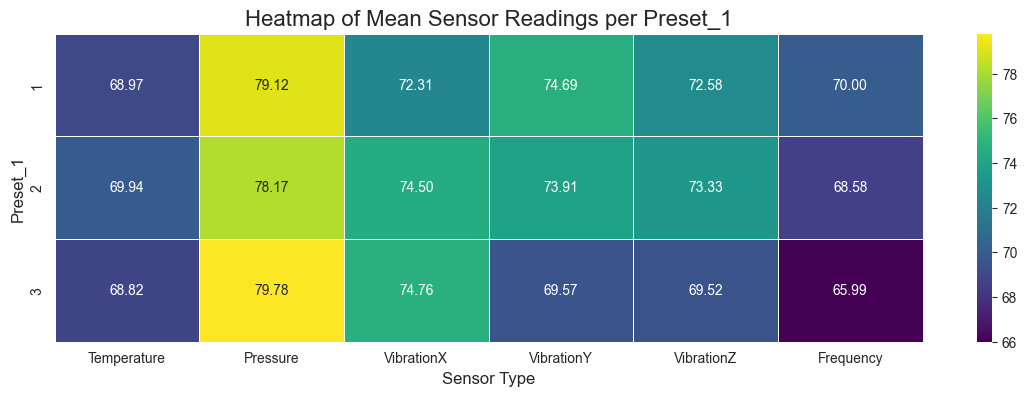

In [12]:
#Checking the mean of each variable for each Preset_1
plt.figure(figsize=(14, 4))
sns.heatmap(
    df.groupby(['Preset_1']).mean()[['Temperature','Pressure','VibrationX','VibrationY','VibrationZ','Frequency']], 
    annot=True,     # Annotate cells with the data values
    fmt=".2f",      # Format annotations to two decimal places
    cmap='viridis', # Use the 'viridis' color map
    linewidths=.5   # Add lines between cells
)

# Add a title and show the plot
plt.title('Heatmap of Mean Sensor Readings per Preset_1', fontsize=16)
plt.xlabel('Sensor Type', fontsize=12)
plt.ylabel('Preset_1', fontsize=12)
plt.show()

Insight 1: Observa-se que a medida que se aumenta o nível do Preset 1 a Vibração no eixo X aumenta e no eixo Y diminui.  
Insight 2: Há correlaçao é sobre a taxa de falha, que é inversamente proporcional ao aumento de nível do Preset 1. Ou seja, Niveis mais baixos estao mais correlacionados à ocorrência de falha.  

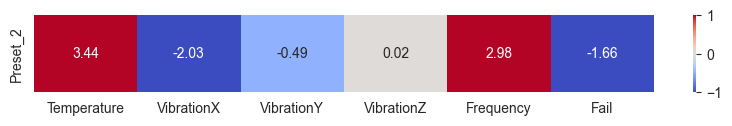

In [13]:
#The same for Preset_2
columns_for_corr = ['Preset_2', 'Temperature', 'VibrationX', 'VibrationY', 'VibrationZ', 'Frequency', 'Fail']
correlation_matrix = df[columns_for_corr].corr(method='pearson')
correlation_matrix = correlation_matrix[correlation_matrix.Preset_2<1][['Preset_2']]*100
correlation_matrix = correlation_matrix.transpose()

plt.figure(figsize=(10, 1))
sns.heatmap(
    correlation_matrix, 
    annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1     
)
plt.show()

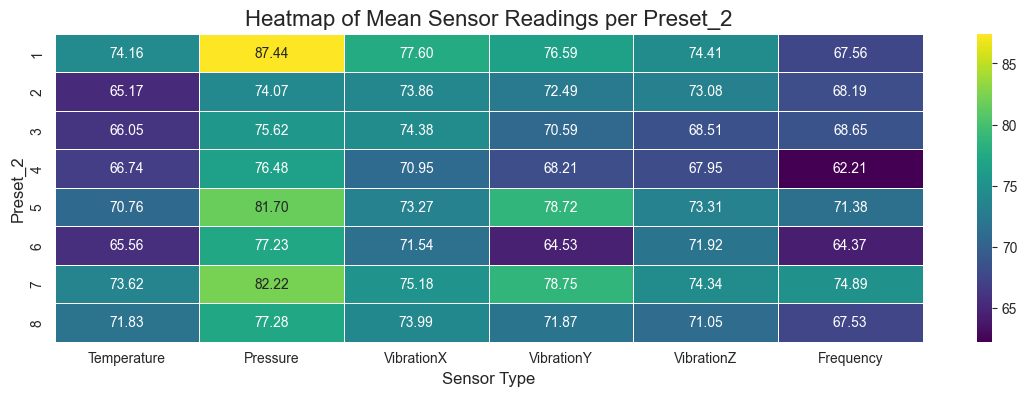

In [14]:
plt.figure(figsize=(14, 4))
sns.heatmap(
    df.groupby(['Preset_2']).mean()[['Temperature','Pressure','VibrationX','VibrationY','VibrationZ','Frequency']], 
    annot=True,     # Annotate cells with the data values
    fmt=".2f",      # Format annotations to two decimal places
    cmap='viridis', # Use the 'viridis' color map
    linewidths=.5   # Add lines between cells
)

# Add a title and show the plot
plt.title('Heatmap of Mean Sensor Readings per Preset_2', fontsize=16)
plt.xlabel('Sensor Type', fontsize=12)
plt.ylabel('Preset_2', fontsize=12)
plt.show()

Insight 3: Pela correlação parece que o aumento de nível do Preset 2 faz aumentar a temperatura do equipamento e da sua frequência de operação. Embora o nível 1 tenha um comportamento bem diferente.

#### Analysing the relationship between Presets and failure

In [15]:
#Feat engineering: Creating sessions where the equipment runs until it fails
df['fail_transition_shift'] = df['fail_transition'].shift(1)
n=0
counter_list=[]
for i in range(df.shape[0]):
    if df.fail_transition_shift[i]==True:
        n+=1
    counter_list.append(n)
df['Fail_Section']=counter_list
df['Fail_Section'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

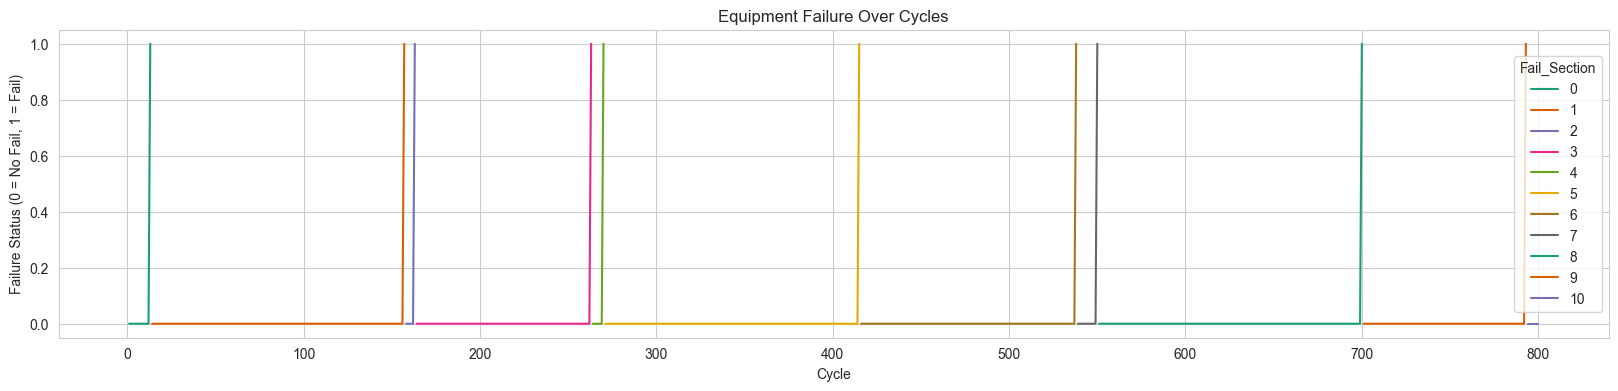

In [16]:
fig = plt.figure(figsize=(20, 4))
sns.lineplot(data=df, x='Cycle', y='fail_transition', hue='Fail_Section', palette='Dark2')
plt.title('Equipment Failure Over Cycles')
plt.xlabel('Cycle')
plt.ylabel('Failure Status (0 = No Fail, 1 = Fail)')    
plt.show()

In [17]:
#Most frequent Preset combination analysis
gb_fail_section = df.groupby(['Fail_Section','Preset_1','Preset_2']).Cycle.count().reset_index()
gb_fail_section = gb_fail_section.sort_values(by=['Fail_Section','Cycle'], ascending=False).drop_duplicates(subset=['Fail_Section'],keep='first')

gb_fail_section.columns = ['Equip operation until failure session','Preset_1','Preset_2','Most frequent preset combination']
gb_fail_section.sort_values(by='Most frequent preset combination',ascending=False)

,Equip operation until failure session,Preset_1,Preset_2,Most frequent preset combination
137,8,2,4,11
13,1,1,3,11
83,5,2,6,10
108,6,2,8,9
151,9,1,2,9
47,3,1,7,8
8,0,2,5,3
174,10,1,4,2
119,7,2,1,2
65,4,1,3,2


In [18]:
#Feat engineering: Creating a cycle counter until each failure
df_aux = df[~((df.Fail==True)&(df.fail_transition==False))].copy()
df_aux.reset_index(drop=True, inplace=True)

counter_list=[]
for section in df_aux.Fail_Section.unique():
    aux=[]
    n=1
    for row in df_aux[df_aux.Fail_Section==section].itertuples():
        aux.append(n)
        n+=1
        if row.fail_transition==True:
            #print('entrou')
            counter_list.extend(aux)
            break

df_aux['equip_runs_counter']=counter_list

In [19]:
#Most frequent Preset's on the last 5 cycles
df_last_5cycles_b4_fail = pd.DataFrame()
for section in df_aux.Fail_Section.unique():
    df_last_5cycles_b4_fail = pd.concat([df_last_5cycles_b4_fail,df_aux[df_aux.Fail_Section==section].tail(5)])

#relationship between equuipment runs and preset's combination
df_last_5cycles_b4_fail = df_last_5cycles_b4_fail.groupby(['Fail_Section','Preset_1','Preset_2']).Cycle.count().reset_index()

#Extraction the most frequent combination for each run
gb_last_5cycles_b4_fail_most_freq = df_last_5cycles_b4_fail.sort_values(by=['Fail_Section','Cycle'], ascending=False).drop_duplicates(subset=['Fail_Section'],keep='first')

gb_last_5cycles_b4_fail_most_freq.columns = ['Equip operation until failure session','Preset_1','Preset_2','Most frequent preset combination']
gb_last_5cycles_b4_fail_most_freq.sort_values(by='Most frequent preset combination',ascending=False)

,Equip operation until failure session,Preset_1,Preset_2,Most frequent preset combination
2,0,2,5,2
17,4,1,3,2
4,1,2,2,2
40,9,1,6,1
35,8,1,1,1
31,7,1,6,1
21,5,1,7,1
26,6,2,2,1
8,2,1,2,1
12,3,1,2,1


In [20]:
#Most frequent preset combination regardless the session
df_last_5cycles_b4_fail.groupby(['Preset_1','Preset_2'])['Cycle'].count().reset_index()\
    .sort_values('Cycle',ascending=False).head()

,Preset_1,Preset_2,Cycle
10,2,5,5
14,3,2,4
8,2,2,3
9,2,3,3
5,1,7,3


Insight 4: Como a falha geralmente não é um evento isolado, parece que p Preset_1 = 2 se mostra frequente nos ultimos ciclos antes da falha.

##### Analise no momento da falha

In [21]:
df_aux[df_aux.fail_transition==True].groupby(['Preset_1']).Cycle.count().reset_index().sort_values(by=['Cycle'], ascending=False)

,Preset_1,Cycle
0,1,5
2,3,4
1,2,1


In [22]:
df_aux[df_aux.fail_transition==True].groupby(['Preset_2']).Cycle.count().reset_index().sort_values(by=['Cycle'], ascending=False)

,Preset_2,Cycle
0,1,3
3,6,3
1,2,2
2,3,1
4,8,1


In [23]:
df_aux[df_aux.fail_transition==True].groupby(['Preset_1','Preset_2']).Cycle.count().reset_index().sort_values(by=['Cycle'], ascending=False)

,Preset_1,Preset_2,Cycle
2,1,6,2
0,1,1,1
1,1,2,1
3,1,8,1
4,2,1,1
5,3,1,1
6,3,2,1
7,3,3,1
8,3,6,1


Insight 5: Conforme a correlaçao de Pearson o Preset 1 está mais relacionado à ocorrencia de falha.

### Task 3: Categorize equipment failures by their nature/root cause according to parameter readings (temperature, pressure, and others).

Analyze patterns in these readings that could indicate specific failure types. How do these patterns differ across operational regimes? Provide insights based on your findings.

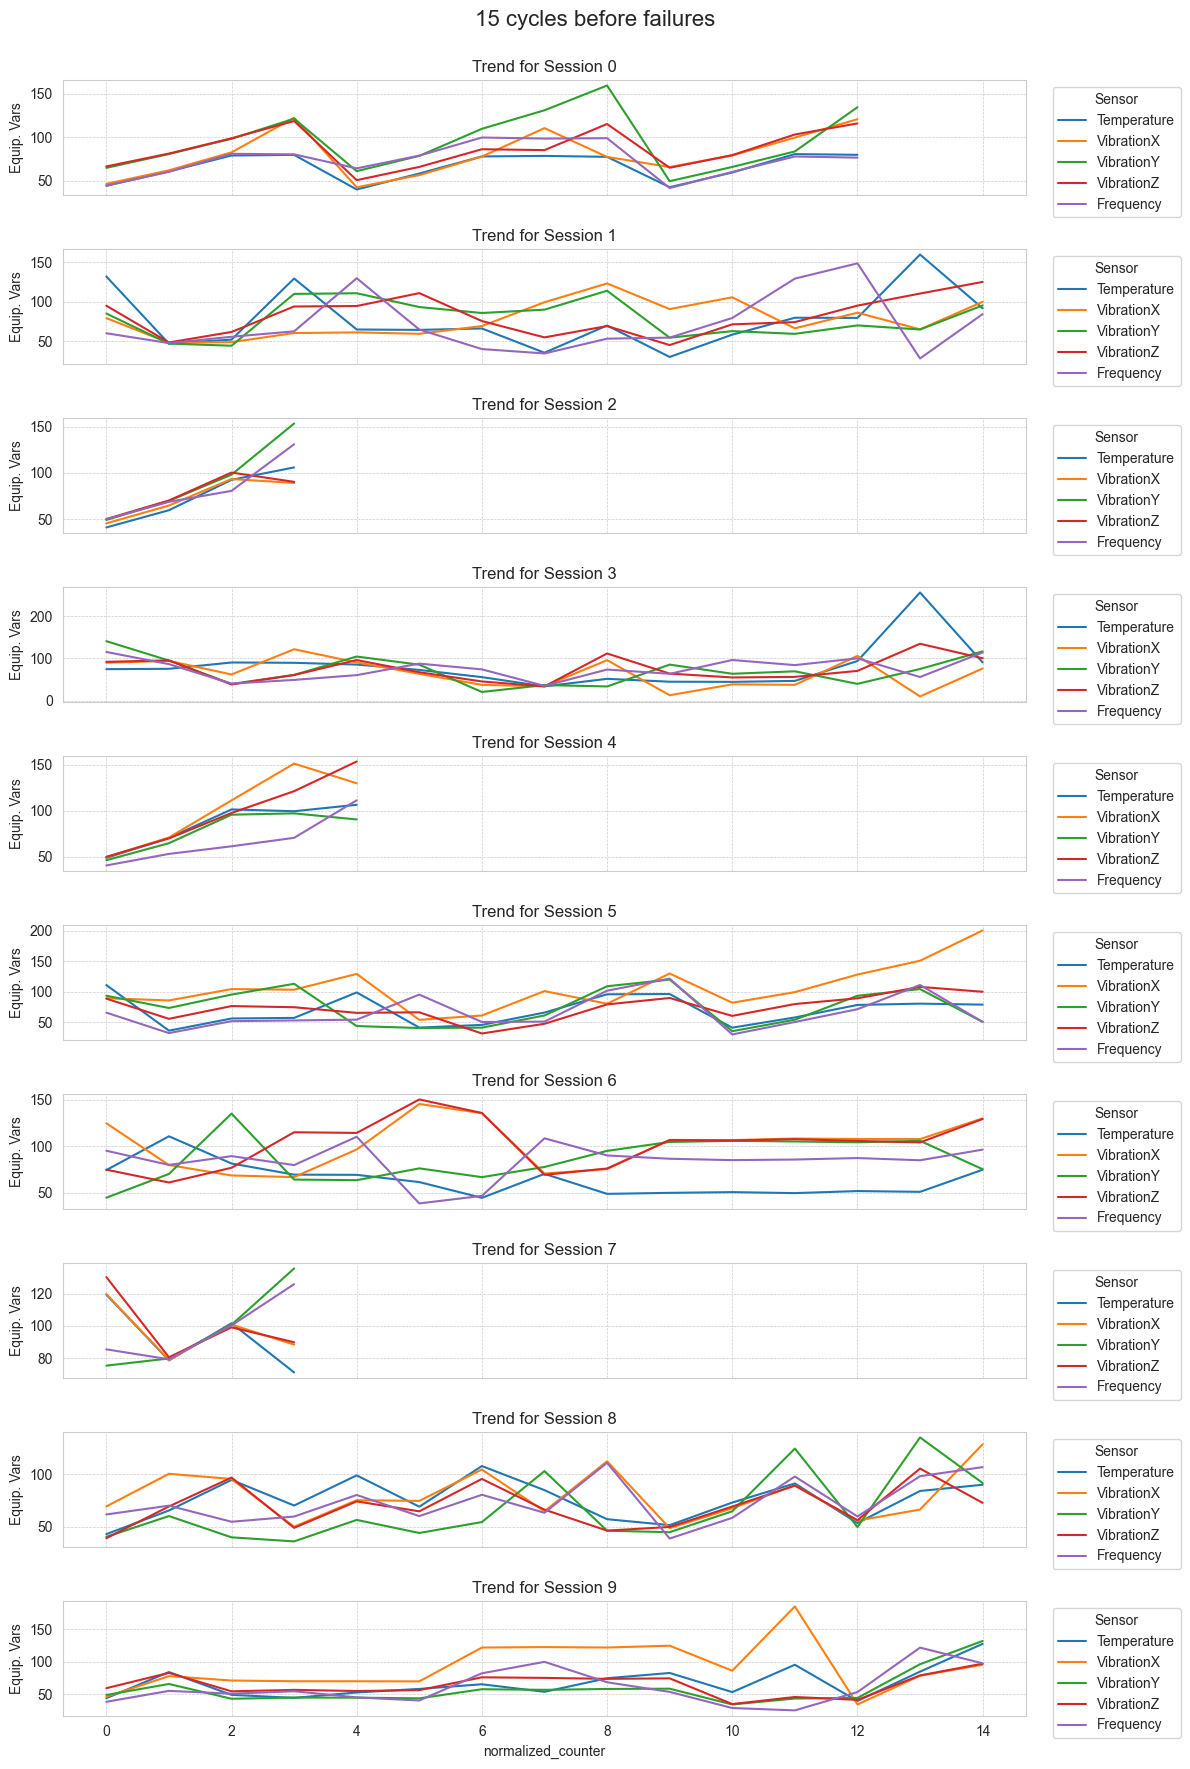

In [24]:
#Checking trends for each Session on the last 15 cycles before failure
df_lastCycles = pd.DataFrame()
for section in df_aux.Fail_Section.unique():
    aux = df_aux[df_aux.Fail_Section==section].tail(15).reset_index().drop(columns='index')
    aux = aux.reset_index().rename(columns={'index':'normalized_counter'})
    df_lastCycles = pd.concat([df_lastCycles,aux])
df_lastCycles = df_lastCycles.reset_index().drop(columns='index')

sns.set_style("whitegrid")
fig, axes = plt.subplots(
    nrows=df_lastCycles.Fail_Section.nunique(), 
    ncols=1, 
    figsize=(12, 18), 
    sharex=True
)

for i, session in enumerate(df_lastCycles.Fail_Section.unique()):

    sns.lineplot(data=df_lastCycles[df_lastCycles.Fail_Section==session], x='normalized_counter', y='Temperature', ax=axes[i], label='Temperature')
    sns.lineplot(data=df_lastCycles[df_lastCycles.Fail_Section==session], x='normalized_counter', y='VibrationX', ax=axes[i], label='VibrationX')
    sns.lineplot(data=df_lastCycles[df_lastCycles.Fail_Section==session], x='normalized_counter', y='VibrationY', ax=axes[i], label='VibrationY')
    sns.lineplot(data=df_lastCycles[df_lastCycles.Fail_Section==session], x='normalized_counter', y='VibrationZ', ax=axes[i], label='VibrationZ')
    sns.lineplot(data=df_lastCycles[df_lastCycles.Fail_Section==session], x='normalized_counter', y='Frequency', ax=axes[i], label='Frequency')
    axes[i].set_title(f'Trend for Session {session}', fontsize=12)
    axes[i].set_ylabel('Equip. Vars')
    axes[i].grid(True, which='both', linestyle='--', linewidth=0.5)
    axes[i].legend(title='Sensor', bbox_to_anchor=(1.02, 1), loc='upper left')

fig.suptitle('15 cycles before failures',size=16)
fig.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

#### Analyzing the Feature Importance on DTC

In [25]:
df_analysis = df_aux[['Preset_1','Preset_2','Fail_Section','equip_runs_counter','Temperature', 'VibrationX', 'VibrationY', 'VibrationZ', 'Frequency','Fail']]

def get_feat_importance(df):
    le = LabelEncoder()
    df['Fail'] = le.fit_transform(df['Fail'])

    # Separate features (X) and target (y)
    X = df.drop(['Fail', 'equip_runs_counter'], axis=1)
    y = df['Fail']

    clf = DecisionTreeClassifier(random_state=42)
    clf.fit(X, y)

    feature_importances = pd.DataFrame({
        'feature': X.columns,
        'importance': clf.feature_importances_
    }).sort_values('importance', ascending=False)

    return feature_importances

FI = {}
for i in df_analysis.Fail_Section.unique():
    FI[f'session_{i}'] = get_feat_importance(df_analysis[df_analysis.Fail_Section==i].drop(columns='Fail_Section'))

In [26]:
#Categoryzing by feat importance
print('<<<Categorização de prováveis motivos de falha pela análise de Feature importance dom DTC>>>\n')
print('-'*100)
for i in FI:
    x = FI[i].sort_values('importance',ascending=False).head(1)
    print(f"A falha da sessão {i} ocorreu por provavelmente pela variável {x.feature}, pelo valor de importância de {x.importance} \n")
    print('-'*100)

<<<Categorização de prováveis motivos de falha pela análise de Feature importance dom DTC>>>

----------------------------------------------------------------------------------------------------
A falha da sessão session_0 ocorreu por provavelmente pela variável 5    VibrationZ
Name: feature, dtype: object, pelo valor de importância de 5    1.0
Name: importance, dtype: float64 

----------------------------------------------------------------------------------------------------
A falha da sessão session_1 ocorreu por provavelmente pela variável 5    VibrationZ
Name: feature, dtype: object, pelo valor de importância de 5    1.0
Name: importance, dtype: float64 

----------------------------------------------------------------------------------------------------
A falha da sessão session_2 ocorreu por provavelmente pela variável 6    Frequency
Name: feature, dtype: object, pelo valor de importância de 6    1.0
Name: importance, dtype: float64 

-------------------------------------------

#### Categorizaçao com Information Value

In [27]:
def calc_iv(df, feature, target, bins=10):
    """
    Calculate Information Value (IV) for one feature inside a DataFrame.
    """
    # Bin if numeric
    if pd.api.types.is_numeric_dtype(df[feature]):
        df = df.copy()
        df["bin"] = pd.qcut(df[feature], q=bins, duplicates="drop")
    else:
        df["bin"] = df[feature]

    # Group by bins
    grouped = df.groupby("bin",observed=False)[target].agg(["count", "sum"])
    grouped.columns = ["total", "bad"]
    grouped["good"] = grouped["total"] - grouped["bad"]

    # Distributions
    grouped["dist_good"] = grouped["good"] / grouped["good"].sum()
    grouped["dist_bad"] = grouped["bad"] / grouped["bad"].sum()

    # Avoid division by zero
    grouped = grouped[(grouped["dist_good"] > 0) & (grouped["dist_bad"] > 0)]

    # WoE & IV
    grouped["WoE"] = np.log(grouped["dist_good"] / grouped["dist_bad"])
    grouped["IV"] = (grouped["dist_good"] - grouped["dist_bad"]) * grouped["WoE"]

    return grouped["IV"].sum()


def iv_per_section(df, features, target="Fail", bins=10):
    """
    Compute IV for each feature inside each Fail_Section.
    Also prints the variable with highest IV per section.
    
    Returns a DataFrame with IV values.
    """
    results = []
    
    for section, group in df.groupby("Fail_Section"):
        section_result = {"Fail_Section": section}
        for feature in features:
            try:
                iv_value = calc_iv(group, feature, target, bins=bins)
            except Exception:
                iv_value = np.nan
            section_result[feature] = iv_value
        results.append(section_result)
    
    iv_df = pd.DataFrame(results).set_index("Fail_Section")
    
    # Print best feature per section
    for section in iv_df.index:
        best_feature = iv_df.loc[section].idxmax()
        best_iv = iv_df.loc[section].max()
        print(f"Fail_Section {section}: Best Feature = {best_feature} (IV={best_iv:.4f})")
    
    return iv_df


features = ["Preset_1", "Preset_2", "Temperature", "Pressure", 
            "VibrationX", "VibrationY", "VibrationZ", "Frequency"]

iv_table = iv_per_section(df, features, target="Fail", bins=5)

Fail_Section 0: Best Feature = Preset_2 (IV=1.4931)
Fail_Section 1: Best Feature = Temperature (IV=1.3114)
Fail_Section 2: Best Feature = Preset_2 (IV=0.1352)
Fail_Section 3: Best Feature = Temperature (IV=1.4363)
Fail_Section 4: Best Feature = Preset_1 (IV=0.4763)
Fail_Section 5: Best Feature = VibrationX (IV=1.3523)
Fail_Section 6: Best Feature = VibrationX (IV=1.2543)
Fail_Section 7: Best Feature = Preset_1 (IV=1.5403)
Fail_Section 8: Best Feature = Temperature (IV=1.4548)
Fail_Section 9: Best Feature = Pressure (IV=1.4053)
Fail_Section 10: Best Feature = Preset_1 (IV=0.0000)


### Task 4: Create a model (or models) using the technique you think is most appropriate and measure its performance

#### Feature Engineering - Creating Windowing for 2 and 4 cycles e Oversampling unbalanced dataset

In [28]:
cols = ['Fail_Section','equip_runs_counter','Preset_1','Preset_2','Temperature','Pressure','VibrationX','VibrationY','VibrationZ','Frequency','Fail']
sensor_cols = ['Temperature','Pressure','VibrationX','VibrationY','VibrationZ','Frequency']
preset_cols = ['Preset_1', 'Preset_2']
window_sizes = [2, 4]
df_model = df_aux[cols].copy()
df_model.sample()

,Fail_Section,equip_runs_counter,Preset_1,Preset_2,Temperature,Pressure,VibrationX,VibrationY,VibrationZ,Frequency,Fail
721,9,58,1,2,94.788891,66.093918,65.208088,112.29868,131.363787,60.814196,False


In [29]:
#Generatiing systetic data for oversampling

new_sections = []
history_window=3
grouped = df_model.groupby("Fail_Section")

# PRESETS
fail_points = df_model[df_model["Fail"] == True]
preset1_dist = fail_points["Preset_1"].value_counts(normalize=True)
preset2_dist = fail_points["Preset_2"].value_counts(normalize=True)

# NOMERICAL
feature_cols = ["Temperature", "Pressure", "VibrationX", "VibrationY", "VibrationZ", "Frequency"]
for new_id in range(10, 50):
    #escolhe section como referência
    template_id = np.random.choice([i for i in grouped.groups.keys()])
    template = grouped.get_group(template_id).copy()
    n_runs = len(template)

    synthetic = []
    for i in range(n_runs):
        row = {}
        row["Fail_Section"] = new_id
        row["equip_runs_counter"] = i + 1
        if i == n_runs - 1:  # last row -> failure
            row["Preset_1"] = np.random.choice(preset1_dist.index, p=preset1_dist.values)
            row["Preset_2"] = np.random.choice(preset2_dist.index, p=preset2_dist.values)
        else:
            row["Preset_1"] = template.iloc[i]["Preset_1"]
            row["Preset_2"] = template.iloc[i]["Preset_2"]
        

        if i >= n_runs - history_window:  # 3 ultimos ciclos são os mais importantes para o modelo (Muito próximo do real)
            last_k = template.iloc[-history_window:][feature_cols]
            mu = last_k.mean()
            sigma = last_k.std(ddof=0) + 1e-3
            for col in feature_cols:
                row[col] = np.random.normal(mu[col], sigma[col])
        else: # Demais ciclos podem distribuir normalmente
            for col in feature_cols:
                val = template.iloc[i][col]
                row[col] = np.random.normal(val, 0.05 * abs(val) + 1e-3)
        
        row["Fail"] = (i == n_runs - 1)
        synthetic.append(row)
    
    new_sections.append(pd.DataFrame(synthetic))

df_model = pd.concat([df_model] + new_sections, ignore_index=True)

df_model.Fail_Section.nunique()

50

In [30]:
for window in window_sizes:

    for col in sensor_cols:
        df_model[f'safra{window}_{col}'] = df_model[col].rolling(window=window).mean()

    for col in preset_cols:
        # This implementation of rolling mode is one of many possibilities. This one takes the mode of the whole window.
        df_model[f'Safra{window}_{col}'] = df_model[col].rolling(window=window)\
            .apply(lambda x: mode(x)[0], raw=False)

df_model.head()

,Fail_Section,equip_runs_counter,Preset_1,Preset_2,Temperature,Pressure,VibrationX,VibrationY,VibrationZ,Frequency,...,Safra2_Preset_1,Safra2_Preset_2,safra4_Temperature,safra4_Pressure,safra4_VibrationX,safra4_VibrationY,safra4_VibrationZ,safra4_Frequency,Safra4_Preset_1,Safra4_Preset_2
0,0,1,3,6,44.235186,47.657254,46.441769,64.820327,66.454520,44.483250,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,2,2,4,60.807234,63.172076,62.005951,80.714431,81.246405,60.228715,...,2.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,3,2,1,79.027536,83.032190,82.642110,98.254386,98.785196,80.993479,...,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,4,2,3,79.716242,100.508634,122.362321,121.363429,118.652538,80.315567,...,2.0,1.0,65.946549,73.592538,78.363038,91.288143,91.284664,66.505253,2.0,1.0
4,0,5,2,5,39.989054,51.764833,42.514302,61.037910,50.716469,64.245166,...,2.0,3.0,64.885017,74.619433,77.381171,90.342539,87.350152,71.445732,2.0,1.0


In [31]:
print(
    '### Resumo da ABT ###',
    '\nNumero de sessões:',df_model.Fail_Section.nunique(),
    '\nNumero de Falhas:',df_model.Fail.sum(),
    '\nVolume da ABT:',df_model.shape[0],
    '\nFeatures da ABT:',df_model.shape[1]
)

### Resumo da ABT ### 
Numero de sessões: 50 
Numero de Falhas: 50 
Volume da ABT: 3800 
Features da ABT: 27


### Baseline com DTC

Accuracy:  0.9890
Precision: 0.6000
Recall:    0.4286
F1-Score:  0.5000
AUC-ROC:   0.6873


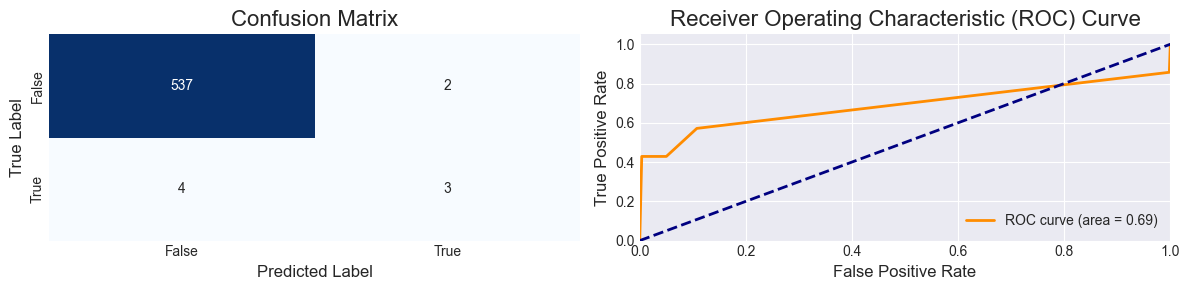

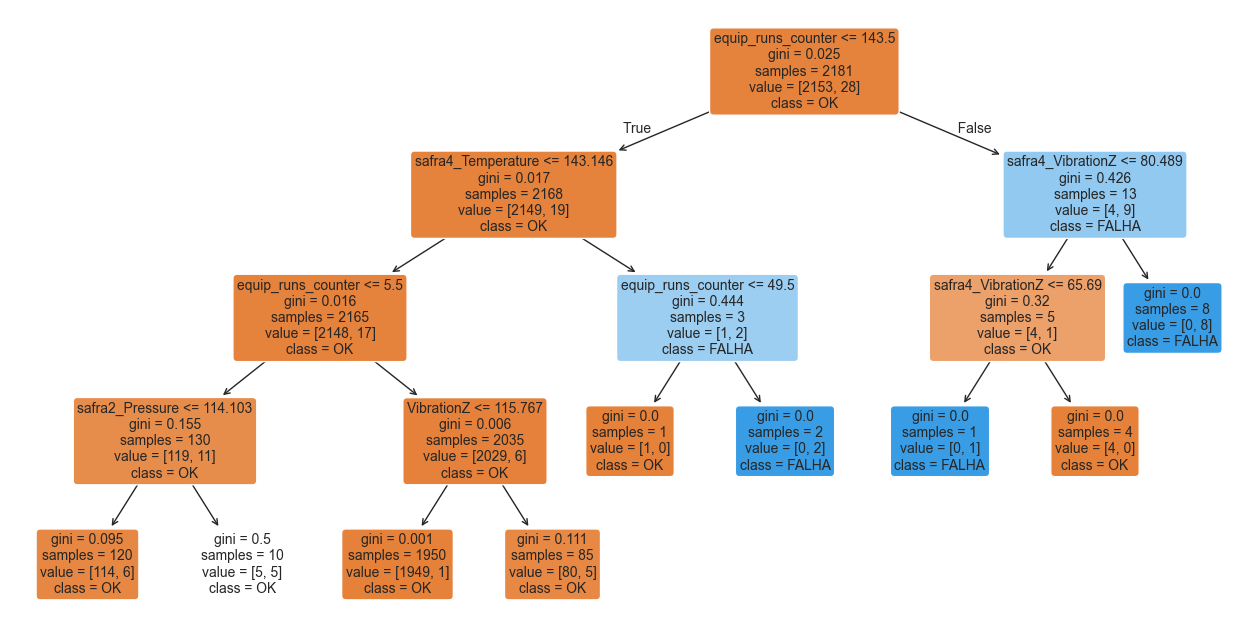

In [32]:
le = LabelEncoder()
df_model['Fail'] = le.fit_transform(df_model['Fail'])
df_train = df_model[df_model.Fail_Section<35]
df_val = df_model[df_model.Fail_Section>=35]

X = df_train.drop(['Fail'], axis=1)
y = df_train['Fail']

X_validation = df_val.drop(['Fail'], axis=1)
Y_validation = df_val['Fail']

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42, stratify=y)

dt = DecisionTreeClassifier(random_state=42, max_depth=4)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
y_pred_proba = dt.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
auc = roc_auc_score(y_test, y_pred_proba)
cm = confusion_matrix(y_test, y_pred)
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"AUC-ROC:   {auc:.4f}")


plt.style.use('seaborn-v0_8-darkgrid')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1, cbar=False, xticklabels=le.classes_, yticklabels=le.classes_)
ax1.set_title('Confusion Matrix', fontsize=16)
ax1.set_xlabel('Predicted Label', fontsize=12)
ax1.set_ylabel('True Label', fontsize=12)

if y_test.sum() > 0:
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    ax2.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc:.2f})')
    ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('False Positive Rate', fontsize=12)
    ax2.set_ylabel('True Positive Rate', fontsize=12)
    ax2.set_title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
    ax2.legend(loc="lower right")
else:
    ax2.text(0.5, 0.5, 'ROC Curve cannot be plotted\n(No positive samples in test set)',
             horizontalalignment='center', verticalalignment='center',
             fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
    ax2.set_title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.tight_layout()
plt.show()


tree_rules = export_text(dt, feature_names=X.columns)
plt.figure(figsize=(16, 8))
plot_tree(
    dt, 
    feature_names=X.columns, 
    class_names=["OK", "FALHA"], 
    filled=True, 
    rounded=True,
    fontsize=10
)
plt.show()

Insight: Performance pífia, porém eu forcei a profundidade das árvores para obter explicabilidade no baseline.

### Resultado com XGB e CrossValidation

In [33]:
xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric="logloss",
    random_state=42
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.1, 0.2],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring="roc_auc",   # choose metric: accuracy, f1, recall, etc.
    cv=cv,
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X, y)
print("Best Parameters:", grid_search.best_params_)
print("Best ROC AUC:", grid_search.best_score_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Best ROC AUC: 0.9769650727089465


c:\Users\Renan\Documents\Developer\shape_case\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:47:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


c:\Users\Renan\Documents\Developer\shape_case\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:47:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy:  0.9907
Precision: 0.8571
Recall:    0.4000
F1-Score:  0.5455
AUC-ROC:   0.6873


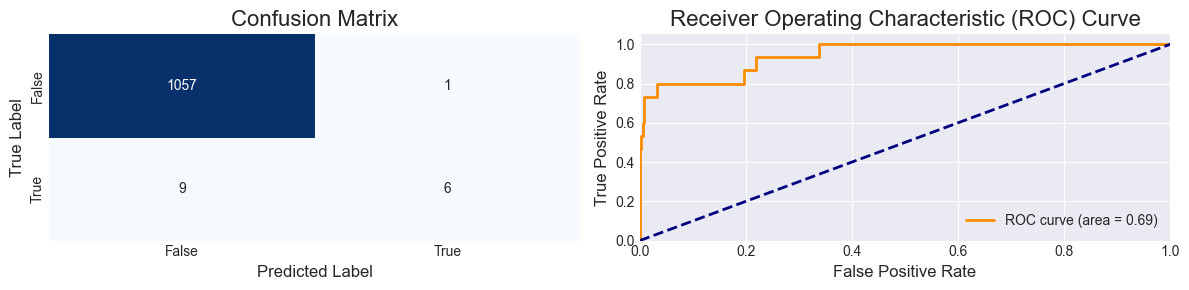

In [34]:
best_params = grid_search.best_params_
best_model = XGBClassifier(
    **best_params,
    use_label_encoder=False,
    eval_metric="logloss",
    random_state=42
)

best_model.fit(X, y)
y_pred = best_model.predict(X_validation)
y_proba = best_model.predict_proba(X_validation)[:, 1]

accuracy = accuracy_score(Y_validation, y_pred)
precision = precision_score(Y_validation, y_pred, zero_division=0)
recall = recall_score(Y_validation, y_pred, zero_division=0)
f1 = f1_score(Y_validation, y_pred, zero_division=0)
cm = confusion_matrix(Y_validation, y_pred)
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"AUC-ROC:   {auc:.4f}")

plt.style.use('seaborn-v0_8-darkgrid')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1, cbar=False, xticklabels=le.classes_, yticklabels=le.classes_)
ax1.set_title('Confusion Matrix', fontsize=16)
ax1.set_xlabel('Predicted Label', fontsize=12)
ax1.set_ylabel('True Label', fontsize=12)

if y_test.sum() > 0:
    fpr, tpr, _ = roc_curve(Y_validation, y_proba)
    ax2.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc:.2f})')
    ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('False Positive Rate', fontsize=12)
    ax2.set_ylabel('True Positive Rate', fontsize=12)
    ax2.set_title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
    ax2.legend(loc="lower right")
else:
    ax2.text(0.5, 0.5, 'ROC Curve cannot be plotted\n(No positive samples in test set)',
             horizontalalignment='center', verticalalignment='center',
             fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
    ax2.set_title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.tight_layout()
plt.show()

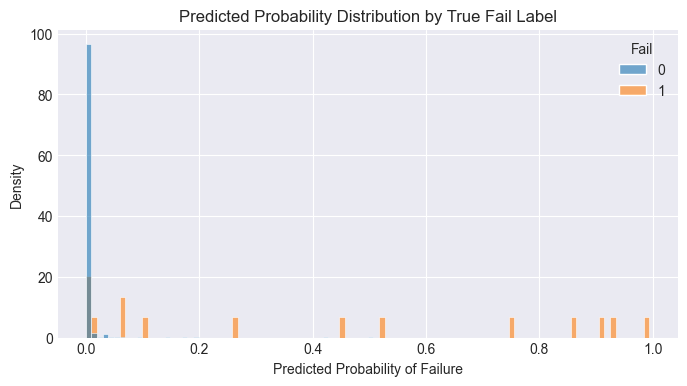

In [35]:
proba_df = pd.DataFrame({
    "Fail": Y_validation,
    "proba": y_proba
})

# Plot histogram of probability scores
plt.figure(figsize=(8,4))
sns.histplot(
    data=proba_df,
    x="proba",
    hue="Fail",
    bins=100,
    stat="density",
    common_norm=False,
    alpha=0.6
)
plt.title("Predicted Probability Distribution by True Fail Label")
plt.xlabel("Predicted Probability of Failure")
plt.ylabel("Density")
plt.show()

In [36]:
proba_df[proba_df.Fail==0].proba.describe(percentiles=np.arange(0.95,1,0.01))

count    1058.000000
mean        0.002930
std         0.023405
min         0.000001
50%         0.000043
95%         0.006956
96%         0.010575
97%         0.016250
98%         0.030472
99%         0.043476
100%        0.504162
max         0.504162
Name: proba, dtype: float64

Accuracy:  0.9870
Precision: 0.5238
Recall:    0.7333
F1-Score:  0.6111
AUC-ROC:   0.6873


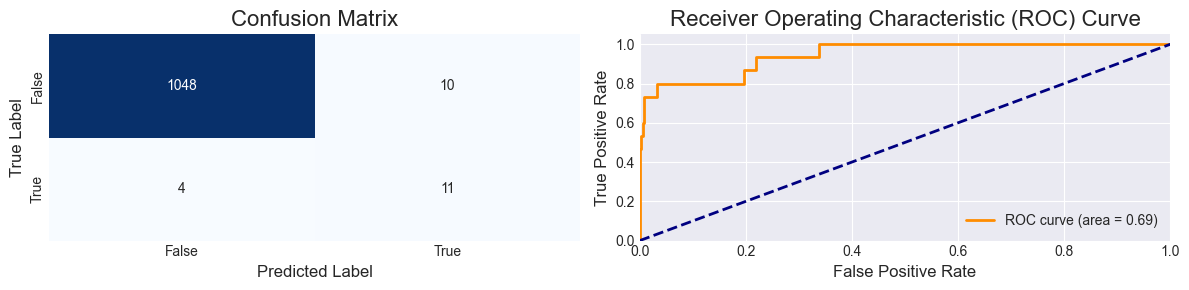

In [37]:
proba_df['y_pred_v2'] = np.where(proba_df.proba>0.05,1,0)
y_pred_v2 = proba_df['y_pred_v2']
accuracy = accuracy_score(Y_validation, y_pred_v2)
precision = precision_score(Y_validation, y_pred_v2, zero_division=0)
recall = recall_score(Y_validation, y_pred_v2, zero_division=0)
f1 = f1_score(Y_validation, y_pred_v2, zero_division=0)
cm = confusion_matrix(Y_validation, y_pred_v2)
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"AUC-ROC:   {auc:.4f}")

plt.style.use('seaborn-v0_8-darkgrid')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1, cbar=False, xticklabels=le.classes_, yticklabels=le.classes_)
ax1.set_title('Confusion Matrix', fontsize=16)
ax1.set_xlabel('Predicted Label', fontsize=12)
ax1.set_ylabel('True Label', fontsize=12)

if y_test.sum() > 0:
    fpr, tpr, _ = roc_curve(Y_validation, y_proba)
    ax2.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc:.2f})')
    ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('False Positive Rate', fontsize=12)
    ax2.set_ylabel('True Positive Rate', fontsize=12)
    ax2.set_title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
    ax2.legend(loc="lower right")
else:
    ax2.text(0.5, 0.5, 'ROC Curve cannot be plotted\n(No positive samples in test set)',
             horizontalalignment='center', verticalalignment='center',
             fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
    ax2.set_title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.tight_layout()
plt.show()

Agora com um modelo menos desbalanceado e com janelamento a performance está aceitável:
- Precisão: A cada ~2 predições de falha acertamos 1
- Recall: A cada ~2 falhas reais acertamos 1

### 5. Analyze variable importance.

C:\Users\Renan\AppData\Local\Temp\ipykernel_10176\1501847433.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x="Importance", y="Feature", palette="viridis")


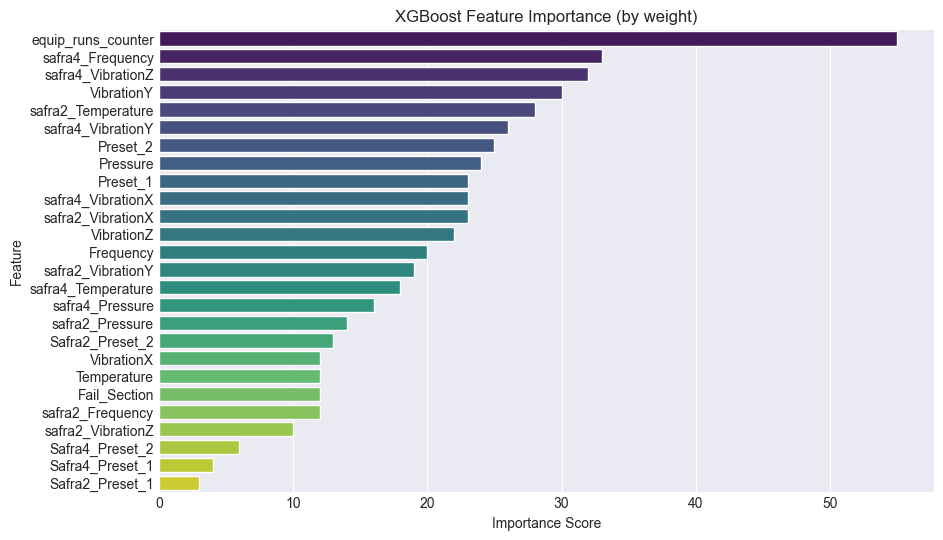

In [38]:
importance_dict = best_model.get_booster().get_score(importance_type="weight")

importance_df = pd.DataFrame({
    "Feature": list(importance_dict.keys()),
    "Importance": list(importance_dict.values())
}).sort_values(by="Importance", ascending=False)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(data=importance_df, x="Importance", y="Feature", palette="viridis")
plt.title("XGBoost Feature Importance (by weight)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()